Cultivation of agricultural crops is highly dependent of the precipitation regime, temperature regime, and soil type of the region. However, these varaibles typically exhibit different spatial patterns, creating different zones or sub-regions with unique environmental attributes and yield potential.

In this exercise we will use three layers of information to divide the state of Kansas into homogeneous agrozones. The selected variables are:

- **30-year annual cumulative thermal units**: Growing degree days or thermal units are highly correlated with crop growth and development. This variable exhibits a North-South gradient, with portions in the southern part of the state exposed to higher temperatures, and therefore greater cumulative thermal units. Source layer: Parameter elevation Regression on Independent Slopes Model (PRISM)

- **30-year annual precipitation**: Precipitation is arguably one of the most important factors conditioning vegetation growth. The state of Kansas exhibits a strong East-West gradient, with eastern Kansas receiving about three times more precipitation per year (1200 mm per year) than western Kansas (400 mm per year). Source layer: Parameter elevation Regression on Independent Slopes Model (PRISM)

- **Sand content at 5 cm depth**: Soil fertility and water holding capacity are major drivers of crop growth and yield. Agricultural crops are often planted in rich, fertile soils. Generally speaking, sandy soils have low fertility and low water holding capacity. So, in this exercise we will use the percetnage of sand content in the top 5 cm as a proxy variable to represent different soil types. Source: SoilGrids, International Soil Reference and Information Centre.


Thermal units and annual precipitation are coarse regulators of potentially viable regions for agricultural crops, while sand content is a fine regulator.


In [54]:
# Import modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score


In [2]:
# Read geotiff layers
gdd = xr.open_dataarray('../datasets/clustering/gdd_30_years.tif')
precip = xr.open_dataarray('../datasets/clustering/precip_30_years.tif')
sand = xr.open_dataarray('../datasets/clustering/sand_0_5_cm.tif')


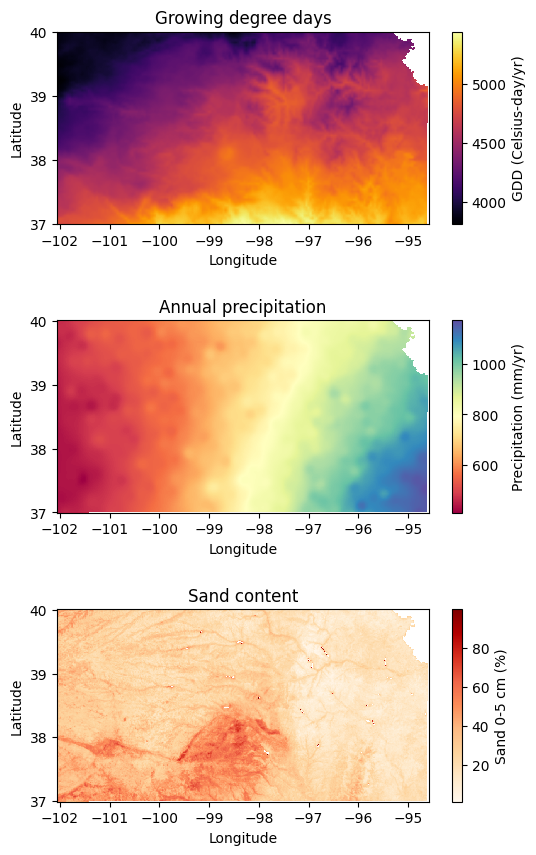

In [3]:
# Create figure to inspect each layer
plt.figure(figsize=(6, 10))

plt.subplot(3,1,1)
gdd.plot(cmap='inferno', cbar_kwargs={'label':'GDD (Celsius-day/yr)'})
plt.title('Growing degree days')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.axis('equal')

plt.subplot(3,1,2)
precip.plot(cmap='Spectral', cbar_kwargs={'label':'Precipitation (mm/yr)'})
plt.title('Annual precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
sand.plot(cmap='OrRd', cbar_kwargs={'label':'Sand 0-5 cm (%)'})
plt.title('Sand content')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplots_adjust(hspace=0.5)

plt.show()

In [4]:
# Find sand content for a single point
sand.sel(x=-100.8, y=37.9, method='nearest').data


array([54.24156397])

Text(0, 0.5, 'Latitude')

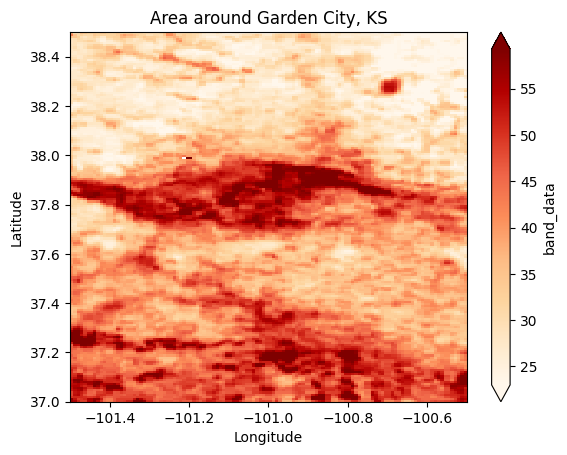

In [7]:
# Plot sand content around Garden City, KS
sand.sel(x=slice(-101.5, -100.5), y=slice(38.5,37.0)).plot(cmap='OrRd', robust=True);
plt.title('Area around Garden City, KS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Preparing data for clustering

The clustering routine in Scikit-learn cannot handle missing values (i.e., NaN). Because our maps contain NaN values to indicate pixels outside of the state boundary or pixels over water bodies (like lakes and ponds), we need to assign a placeholder to these pixels before clustering. Rather that assigning zero, we will assign a negative value that is very different from other values in our dataset. When we are done with the clustering process, we will revert the mask using the NaN values.

Clustering also requires normalizing the input data. The K-means appraoch treats all values equally when computing distances between data points. If one variable has a larger scale than others, it will dominate the clustering process. Normalizing the data ensures that all dimensions contribute equally to the clustering.

In [8]:
# Ensure all the layers have the same dimension.
print(gdd.shape)
print(precip.shape)
print(sand.shape)


(1, 362, 897)
(1, 362, 897)
(1, 362, 897)


Sometimes raster layers have different dimensions (different spatial resolution). In that case, we need to first resample to upscale or downscale the raster dimensions, so that all layers have the same shape. The code below shows how to do this for an arbitrary shape:

```python
Reproject the DataArray to the new resolution
from rasterio.enums import Resampling
reprojected_sand = sand.rio.reproject(sand.rio.crs, 
                                     shape=(500, 1200),
                                    resampling=Resampling.cubic)
```

In [30]:
# Convert 2D arrays into 1D arrays
X_gdd = gdd.data.flatten()
X_precip = precip.data.flatten()
X_sand = sand.data.flatten()

# Find grid cells with NaN values in any layer
# Pixels with NaN values in at least one feature will be set to NaN
idx_nan = np.isnan(X_gdd) | np.isnan(X_precip) | np.isnan(X_sand)

# Replace the NaN values with -999.0
X_gdd[idx_nan] = -1.0
X_precip[idx_nan] = -1.0
X_sand[idx_nan] = -1.0

# Create aray of inputs ((n_samples by n_features))
X = np.column_stack( (X_gdd, X_precip, X_sand) )

# Inspect shape of resulting input array
print(X.shape)


(324714, 3)


## Normalization

We will use the `normalize` function from Scikit Learn that implements an L2 normalization, which is also known as Euclidean normalization. This normalization technique consists of dividing a vector (our feature) by its Euclidean norm. The Euclidean norm of a vector is the square root of the sum of the squares of its elements.


In [31]:
# Normalize (0=normalize each feature, 1=normalize each sample)
X_normalized = normalize(X, axis=0)

# Alternatively you can compute your own normalizing metric (like the z-score)
#X_normalized = (X - X.mean(axis=0))/X.std(axis=0)


In [32]:
# Find best number of clusters
cluster_range = list(range(2,10))
score = []
for k in cluster_range:
    clusters = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X_normalized)
    rand_samples = np.random.randint(X_normalized.shape[0], size=(5_000))
    score.append(silhouette_score(X_normalized[rand_samples,:], 
                                  clusters.labels_[rand_samples]))


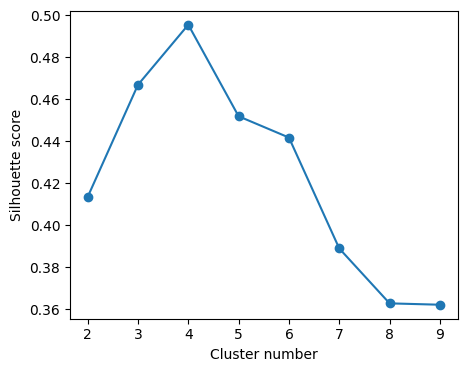

In [33]:
# Visualize Silhouette_score
plt.figure(figsize=(5,4))
plt.plot(cluster_range, score, 'o-')
plt.xlabel('Cluster number')
plt.ylabel('Silhouette score')
plt.show()

It seems that the best number of clusters is 4. However, remember that we have one cluster for the mask (all the values set to -1). So the correct number of clusters defining the agro zones is 3.

In [56]:
# Cluster the data
k = 3 + 1 # Add an extra cluster for the mask pixels
clusters = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X_normalized)


From the Scikit-Learn documentation: "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."

In [57]:
# Check type of a single value of the resulting cluster labels
print(type(clusters.labels_[0]))


<class 'numpy.int32'>


In [58]:
# Convert to float so that we can bring back the NaN values
# to mask the resulting image
cluster_labels = clusters.labels_.astype(np.float64)

# Restore mask
cluster_labels[idx_nan] = np.nan
print(cluster_labels.shape)

(324714,)


In [59]:
# Reshape cluster labels so that they match the shape of the original maps.
cluster_labels = np.reshape(cluster_labels, sand.data.shape)
print(cluster_labels.shape) # Check that we changed the shape of the array

(1, 362, 897)


In [60]:
# Add extra dimension
#cluster_labels = np.expand_dims(cluster_labels, axis=0) 
agro_regions = xr.DataArray(cluster_labels, coords=sand.coords, dims=sand.dims)


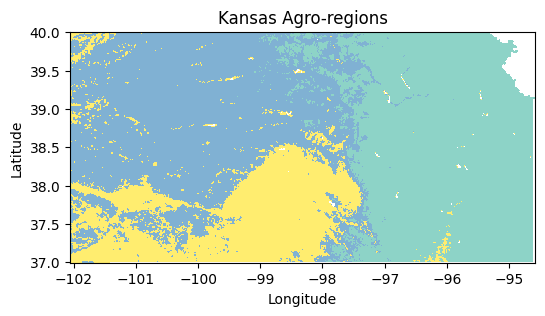

In [67]:
# Plot map (use the x and y coordinates from another layer since the cluster labels don't have coordinates)
plt.figure(figsize=(6,3))
agro_regions.plot(cmap='Set3', add_colorbar=False)
plt.title('Kansas Agro-regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Create summary of properties for each regions

Now that we have divided the state in regions of more homogeneous conditions, let's generate a summary table with the median values of each property for each zone.

In [62]:
# Find a way to get unique labels in the map
labels = np.unique(cluster_labels[~np.isnan(cluster_labels)])
print(labels)

[0. 1. 3.]


A missing label is likely due to the placeholder for NaN values. This label was removed when we brought the NaN values back to the image.


In [65]:
# Iterate over each label and print the median values for each layer
for label in labels:
    
    # Create boolean array for current cluster label
    idx = cluster_labels == label
    
    # Create separate strings to keep lines shorter
    txt_gdd = f"GDD:{round(np.median(gdd.data[idx]))} °C-day per year"
    txt_precip = f"PRECIP:{round(np.median(precip.data[idx]))} mm"
    txt_sand = f"SAND:{round(np.median(sand.data[idx]))} %"
    
    # Print all the strings together
    print(f"Cluster {label} =>  {txt_gdd}, {txt_precip}, {txt_sand}")

Cluster 0.0 =>  GDD:4705 °C-day per year, PRECIP:944 mm, SAND:16 %
Cluster 1.0 =>  GDD:4358 °C-day per year, PRECIP:560 mm, SAND:27 %
Cluster 3.0 =>  GDD:4830 °C-day per year, PRECIP:656 mm, SAND:46 %


## Practice

- Combine the inputs array `X` with the cluster labels and create a Pandas Dataframe to easily compute descriptive statistics using the `groupby()` method.

- Partition the state of Kansas using a different number of regions. What type of regions can be detected by using a higher number of clusters? What happens if you only divide the state into 3 regions?

- Which of the three variables would dominated the clustering process if the input variables are not normalized?

- Can you run a similar analysis for your own state?
